In [1]:
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd())
from hawkes import dataLoader, inference, simulate

ModuleNotFoundError: No module named 'tick'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Generate Fake Data

## Create Fake Params

In [31]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .6
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

In [32]:
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

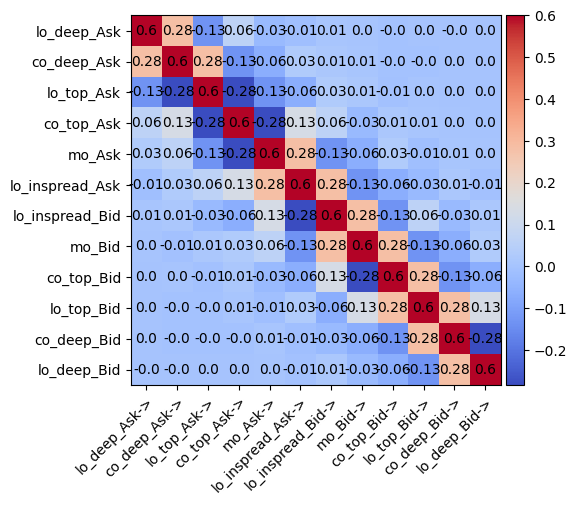

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
# plt.show()


In [34]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

(0.9770300581224621+0j)

In [35]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0
with open("fakeData_Params_sod_eod_dictTOD_constt", "wb") as f:
    pickle.dump(faketod, f)

In [36]:
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

In [37]:
mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])

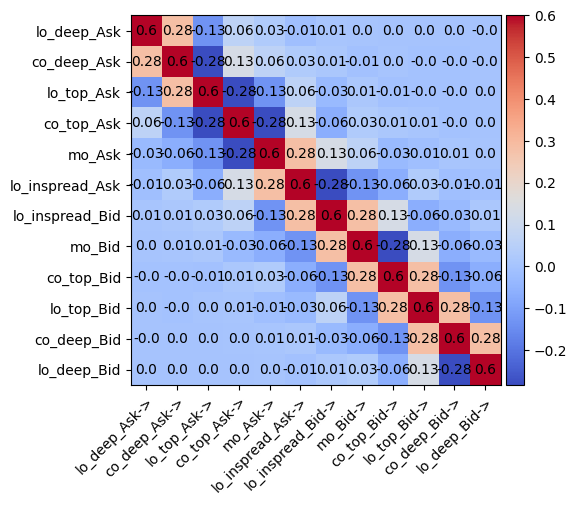

In [38]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [39]:
with open("fake_ParamsInferredWCutoff_sod_eod_true", "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [40]:
os.mkdir("./simulated_data")

In [41]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(10):
    T, lob, lobL3=simulate.simulate(100, "fake_ParamsInferredWCutoff_sod_eod_true", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)

spectral radius =  (0.9770300581224618+0j)
[0.06, 0.06, 0.03, 0.04000000000000001, 0.05, 0.3000000000000256, 0.3000000000000256, 0.04000000000000001, 0.05, 0.04000000000000001, 0.04000000000000001, 0.06999999999999999]
1.0800000000000514
[0.06, 0.06, 0.03, 0.04000000000000001, 0.05, 1.5000000000002558, 1.5000000000002558, 0.04000000000000001, 0.05, 0.04000000000000001, 0.04000000000000001, 0.06999999999999999]
3.4800000000005116
0.6986225633688222
15607.716136530049
    event      time  size
0  mo_Ask  0.698623     1
{'Ask_touch': (45.02, 418), 'Bid_touch': (44.97, 100), 'Ask_deep': (45.03, 1000), 'Bid_deep': (44.96, 1009)}
spectral radius =  (0.9770300581224618+0j)
15607.716136530049
[0.0, 0.0, 0.0, 0.0, 3417.2846838535165, 5501.488147055111, 5732.902996361392, 312.2586952835913, 0.0, 0.0, 24.013988375411756, 16.33080744891934]
15004.279318377941
2.5688497796991703e-06
31516.084303653646
             event      time  size
0  lo_inspread_Bid  0.698625   100
{'Ask_touch': (45.02, 418), 

In [45]:
# save as 12D 
paths = [i for i in os.listdir(os.getcwd()+"/simulated_data") if ("fake_simulated" in i)]
for p in paths:
    resPath = os.getcwd()+"/simulated_data//" + p
    with open(resPath, 'rb') as f:
        results = pickle.load(f)
    
    ask_t = []
    bid_t = []
    ask_d = []
    bid_d= []
    event = []
    time = []
    for r, j in zip(results[1][1:], results[0][1:]):
        ask_t.append(r['Ask_touch'][0])
        bid_t.append(r['Bid_touch'][0])
        ask_d.append(r['Ask_deep'][0])
        bid_d.append(r['Bid_deep'][0])
        event.append(j[0])
        time.append(j[1])
    df = pd.DataFrame({"Time" : time, "event" : event, "Ask Price 1" : ask_t, "Bid Price 1": bid_t, "Ask Price 2": ask_d, "Bid Price 2" : bid_d})
    df['BidDiff'] = df['Bid Price 1'].diff()
    df['AskDiff'] = df['Ask Price 1'].diff()
    df['BidDiff2']= df['Bid Price 2'].diff()
    df['AskDiff2']= df['Ask Price 2'].diff()
    id = (resPath.split("/")[-1]).split("_")[-1]
    df["Date"] = id
    df.to_csv("./simulated_data/fake_" + id +"_12D.csv")

In [44]:
paths

['fake_simulated_sod_eod_0',
 'fake_simulated_sod_eod_1',
 'fake_simulated_sod_eod_2',
 'fake_simulated_sod_eod_3',
 'fake_simulated_sod_eod_4',
 'fake_simulated_sod_eod_5',
 'fake_simulated_sod_eod_6',
 'fake_simulated_sod_eod_7',
 'fake_simulated_sod_eod_8',
 'fake_simulated_sod_eod_9']

## Bin to custom bins

In [69]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
ric = "fake"
for d in range(10):
    l =  dataLoader.Loader(ric, d, d, dataPath = "./simulated_data/")
    df = pd.read_csv(l.dataPath+"fake_"+str(d)+"_12D.csv")
    data = {str(d) : list(df.groupby('event')['Time'].apply(np.array)[cols].values)}
    cls = fit.ConditionalLeastSquaresLogLin(data, loader = l) 
    cls.runTransformDate()

0
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
no previous data cache found
1
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
no previous data cache found
2
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
no previous data cache found
3
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
no previous data cache found
4
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
no previous data cache found
5
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_insprea

# Fit Fake Data

## Hawkes Graph

In [ ]:
!git clone https://github.com/achab/nphc.git nphc2
# in line 1 of nphc2/nphc/cumulants.py, remove the autojit import and line 235 remove decorator

In [50]:
os.getcwd()+"/nphc2"

'/home/konajain/code/lobSimulations/nphc2'

In [51]:
import sys
import os
sys.path.append(os.getcwd()+"/nphc2")
import matplotlib.pyplot as plt
from nphc.main import NPHC
import pandas as pd
import datetime as dt
import numpy as np

In [53]:
big_data = []
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]
for d in range(10): #pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
    
    df = pd.read_csv("./simulated_data/fake_"+str(d)+"_12D.csv")
    
    timestamps = list(df.groupby('event')['Time'].apply(np.array)[cols].values)
    big_data.append(timestamps)

In [54]:
nphc = NPHC()
nphc.fit(big_data,half_width=1.,filtr="rectangular",method="parallel_by_day")
cumulants_list = [nphc.L, nphc.C, nphc.K_c]
from nphc.main import starting_point
start_point = starting_point(cumulants_list, random=True)
R_pred = nphc.solve(training_epochs=50000,display_step=500,learning_rate=1e-2,optimizer='adam')
d = len(nphc.L[0])
from scipy.linalg import inv
G_pred = np.eye(d) - inv(R_pred)

L is computed
C is computed
K_c is computed


/home/konajain/code/nphc2/nphc/main.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  R0 = tf.constant(start_point.astype(np.float64), shape=[d,d])
2024-05-23 18:09:36.641130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Epoch: 0000 log10(cost)= 3.648253324
Epoch: 0500 log10(cost)= 3.262564286
Epoch: 1000 log10(cost)= 3.218139485
Epoch: 1500 log10(cost)= 3.176050730
Epoch: 2000 log10(cost)= 3.144057327
Epoch: 2500 log10(cost)= 3.124117960
Epoch: 3000 log10(cost)= 3.109171281
Epoch: 3500 log10(cost)= 3.096250169
Epoch: 4000 log10(cost)= 3.084005720
Epoch: 4500 log10(cost)= 3.076168409
Epoch: 5000 log10(cost)= 3.068693184
Epoch: 5500 log10(cost)= 3.065765577
Epoch: 6000 log10(cost)= 3.061369609
Epoch: 6500 log10(cost)= 3.056894211
Epoch: 7000 log10(cost)= 3.053536539
Epoch: 7500 log10(cost)= 3.052193615
Epoch: 8000 log10(cost)= 3.050651817
Epoch: 8500 log10(cost)= 3.049578653
Epoch: 9000 log10(cost)= 3.045967167
Epoch: 9500 log10(cost)= 3.045866793
Epoch: 10000 log10(cost)= 3.044093520
Epoch: 10500 log10(cost)= 3.042903693
Epoch: 11000 log10(cost)= 3.044728485
Epoch: 11500 log10(cost)= 3.041147597
Epoch: 12000 log10(cost)= 3.040579876
Epoch: 12500 log10(cost)= 3.043338307
Epoch: 13000 log10(cost)= 3.0424

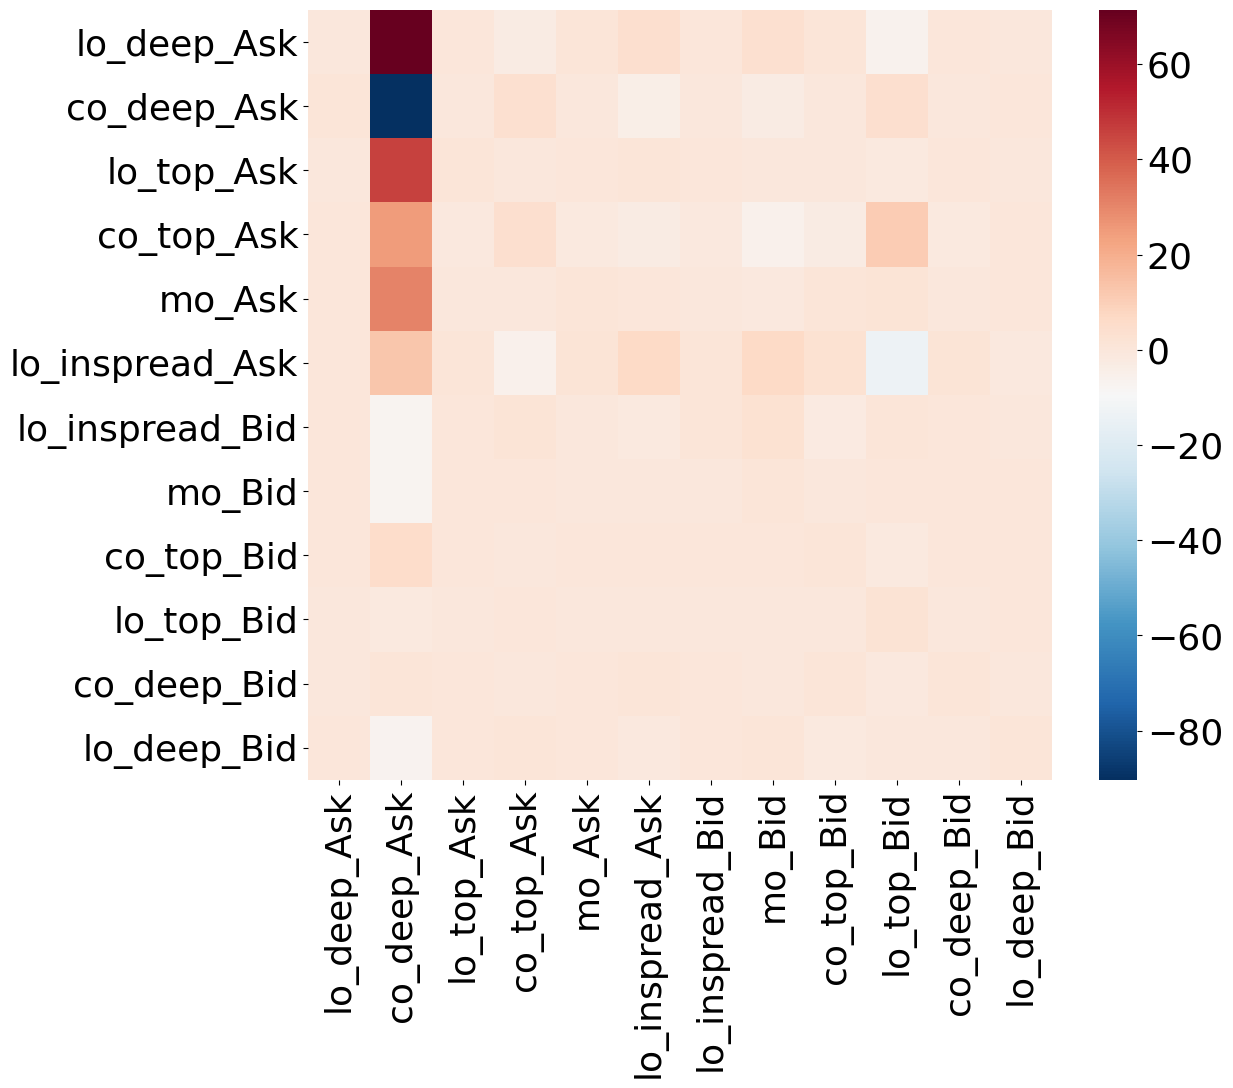

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
dimensions = cols 
sns_plot = sns.heatmap(G_pred.T,cmap="RdBu_r",xticklabels=dimensions,yticklabels=dimensions)

In [60]:
boundsDict = {}
for i in range(12):
    for j in range(12):
        boundsDict[cols[i]+"->"+cols[j]] = np.sign(G_pred[i][j])
import pickle
with open(os.getcwd()+"/simulated_data/fake_2019-01-02_2019-03-31_graphDict", "wb") as f:
    pickle.dump(boundsDict, f)

## 12D Hawkes Non-Parametric Fit:

In [70]:
ric = "fake"
dictIp = {}
d = 0
l =  dataLoader.Loader(ric, d, d, dataPath = "./simulated_data/")
for d in range(10):
    dictIp[str(d)] = []
cls = fit.ConditionalLeastSquaresLogLin(dictIp, loader = l, solver="osqp", path_dictTOD = "./fakeData_Params_sod_eod_dictTOD_constt")
thetas = cls.fitConditionalInSpread(spreadBeta = 1., avgSpread = 1.)
with open(l.dataPath + ric + "_Params_2019-01-02_2019-03-31_CLSLogLin_19" , "wb") as f:
    pickle.dump(thetas, f)

lo_deep_Ask
(21,)
(21,)
      bin  lo_deep_Ask  spread
0       1            1    0.01
1  111632            1    0.01
2  113991            1    0.01
3  114004            2    0.01
4  114005            2    0.01
co_deep_Ask
(25,)
(25,)
      bin  co_deep_Ask  spread
0       1            1    0.01
1  105703            1    0.01
2  186243            1    0.01
3  186259            1    0.01
4  186337            1    0.01
lo_top_Ask
(12,)
(12,)
      bin  lo_top_Ask  spread
0       1           1    0.01
1      15           1    0.01
2      16           1    0.01
3   33452           1    0.01
4  114090           1    0.01
co_top_Ask
(5,)
(5,)
      bin  co_top_Ask  spread
0       1           1    0.01
1  101886           1    0.01
2  486971           1    0.01
3  544951           5    0.03
4  544952           1    0.03
mo_Ask
(3,)
(3,)
   bin  mo_Ask  spread
0    1       1    0.01
1    2       1    0.01
2    7       1    0.02
lo_inspread_Ask
(7,)
(7,)
      bin  lo_inspread_Ask  spread
0     

ValueError: operands could not be broadcast together with shapes (1043,217) (253,1) 

## Infer power law params:

In [71]:
a, b = inference.run(dt.date(2019,1,2), dt.date(2019,3,31), ric = "fake" , avgSpread = 0.01, spreadBeta=1. , suffix = "_CLSLogLin_19")

FileNotFoundError: [Errno 2] No such file or directory: '/SAN/fca/Konark_PhD_Experiments/extracted/fake_Params_2019-01-02_2019-03-31_CLSLogLin_19'

# Simulate LOB from Fitted Fake Params

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(10):
    T, lob, lobL3=simulate.simulate(6.5*3600, "fake_ParamsInferredWCutoff_2019-01-02_2019-01-31_CLSLogLin_19", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = 0.01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_CLSLogLinFit_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)